**Klasių rinkinys:** katė (cat), automobilis (car), klaviatūra (*keyboard*)

In [ ]:
!pip install fiftyone

In [ ]:
import os
import random
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from datetime import datetime

import fiftyone as fo
import fiftyone.utils.data.exporters as exporters
from google.colab import drive
from google.colab import files

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')
root_dir = '/content/drive/My Drive/3lab'
dataset_dir = f'{root_dir}/dataset'

In [ ]:
# Define the CustomDataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, train = False):
        self.train = train
        self.img_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'labels')

        self.file_list = []

        for filename in os.listdir(self.img_dir):
            fn_no_ext, ext = os.path.splitext(filename)
            if ext == '.jpg':
                self.file_list.append(fn_no_ext)

    def __len__(self):
        return len(self.file_list)

    def transform(self, img, mask):
        img = img.resize((256, 256), Image.NEAREST)
        mask = mask.resize((256, 256), Image.NEAREST)

        if self.train and random.random() > 0.5:
            img = TF.hflip(img)
            mask = TF.hflip(mask)

        img = TF.to_tensor(img)
        img = TF.normalize(img, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

        mask = TF.pil_to_tensor(mask)

        return img, mask

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.file_list[idx] + '.jpg')
        mask_path = os.path.join(self.mask_dir, self.file_list[idx] + '.png')

        img = Image.open(img_path)
        mask = Image.open(mask_path)

        return self.transform(img.convert('RGB'), mask)

In [ ]:
classes = ["Cat", "Car", "Computer keyboard"]
max_samples = 1000
export_dir = "dataset"

In [ ]:
mask_targets = {}

for i, c in enumerate(classes, start = 1):
    mask_targets[i] = c

In [ ]:
# Use GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

In [ ]:
train_path = f'{dataset_dir}/train'
test_path = f'{dataset_dir}/test'

train_dataset = CustomDataset(train_path)
test_dataset = CustomDataset(test_path)

batch_size = 32
num_workers = 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers,
                              persistent_workers=True, drop_last=True, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers,
                              persistent_workers=True, drop_last=True, shuffle=True)

In [ ]:
def denormalize_tensor(tensor):
    tensor = tensor * torch.tensor((0.229, 0.224, 0.225)).view(3, 1, 1)
    tensor += torch.tensor((0.485, 0.456, 0.406)).view(3, 1, 1)

    return tensor

def display(display_list):
    plt.figure(figsize=(20, 20))

    title = ['Input Image', 'True Mask', 'Predicted BG',
             'Predicted Cat', 'Predicted Car', 'Predicted Keyboard']

    for i, tensor in enumerate(display_list):
        mode = 'L'

        if i == 0:
            tensor = denormalize_tensor(tensor)
            mode = 'RGB'

        image = TF.to_pil_image(tensor, mode=mode)

        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(image)
        plt.axis('off')

    plt.show()

In [ ]:
def seconds_to_time(seconds):
    s = int(seconds) % 60
    m = int(seconds) // 60
    if m < 1:
        return f'{s}s'
    h = m // 60
    m = m % 60
    if h < 1:
        return f'{m}m{s}s'
    return f'{h}h{m}m{s}s'

In [ ]:
class UNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 32, (3, 3), padding = 'same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, (3, 3), padding = 'same'),
            torch.nn.ReLU()
        )

        self.block2 = torch.nn.Sequential(
            torch.nn.MaxPool2d((2, 2), (2, 2)),
            torch.nn.Conv2d(32, 64, (3, 3), padding = 'same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, (3, 3), padding = 'same'),
            torch.nn.ReLU()
        )

        self.block3 = torch.nn.Sequential(
            torch.nn.MaxPool2d((2, 2), (2, 2)),
            torch.nn.Conv2d(64, 128, (3, 3), padding = 'same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, (3, 3), padding = 'same'),
            torch.nn.ReLU()
        )

        self.block4 = torch.nn.Sequential(
            torch.nn.MaxPool2d((2, 2), (2, 2)),
            torch.nn.Conv2d(128, 256, (3, 3), padding = 'same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, (3, 3), padding = 'same'),
            torch.nn.ReLU()
        )

        self.block5 = torch.nn.Sequential(
            torch.nn.MaxPool2d((2, 2), (2, 2)),
            torch.nn.Conv2d(256, 512, (3, 3), padding = 'same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, (3, 3), padding = 'same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 256, (3, 3), padding = 'same'),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor = 2)
        )

        self.block6 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 256, (3, 3), padding = 'same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 128, (3, 3), padding = 'same'),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor = 2)
        )

        self.block7 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 128, (3, 3), padding = 'same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 64, (3, 3), padding = 'same'),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor = 2)
        )

        self.block8 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 64, (3, 3), padding = 'same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 32, (3, 3), padding = 'same'),
            torch.nn.ReLU(),
            torch.nn.Upsample(scale_factor = 2)
        )

        self.block9 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 32, (3, 3), padding = 'same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, (3, 3), padding = 'same'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, out_channels, (1, 1))
        )

    def forward(self, x):

        x1 = self.block1(x)
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        x4 = self.block4(x3)
        x5 = self.block5(x4)

        cat4_5 = torch.cat((x4, x5), dim = 1)
        x6 = self.block6(cat4_5)

        cat3_6 = torch.cat((x3, x6), dim = 1)
        x7 = self.block7(cat3_6)

        cat2_7 = torch.cat((x2, x7), dim = 1)
        x8 = self.block8(cat2_7)

        cat1_8 = torch.cat((x1, x8), dim = 1)
        x9 = self.block9(cat1_8)

        return x9

In [ ]:
in_channels = train_dataset[0][0].shape[0]
out_channels = 4

model = UNet(in_channels, out_channels).to(device)

print(f'Parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

Parameter count: 7,856,004


In [ ]:
weight = torch.tensor([0.3, 1.0, 1.0, 1.0]).to(device)

criterion = torch.nn.CrossEntropyLoss(weight=weight)
optimizer = torch.optim.Adam(model.parameters())

start_epoch = 0

if os.path.exists(path := 'UNet.pth'):
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    start_epoch = checkpoint['epoch'] + 1
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print(f"Loaded checkpoint, loss: {checkpoint['loss']}")

Loaded checkpoint, loss: 0.4344472885131836


In [ ]:
model.train()

start_time = datetime.now()
num_epochs = 32

for epoch in range(start_epoch, num_epochs):
    loss_accum = np.array([], dtype = np.float32)

    for i, (images, masks) in enumerate(train_dataloader):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks.squeeze().long())
        loss_accum = np.append(loss_accum, loss.cpu().detach().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    current_time = datetime.now()
    elapsed = seconds_to_time((current_time - start_time).total_seconds())
    mean_loss = np.mean(loss_accum)
    print (f'Epoch [{epoch+1}/{num_epochs}], Time: {elapsed}, Loss: {mean_loss}')

Epoch [1/32], Time: 28s, Loss: 1.2495299577713013
Epoch [2/32], Time: 51s, Loss: 1.1820827722549438
Epoch [3/32], Time: 1m13s, Loss: 1.1393615007400513
Epoch [4/32], Time: 1m36s, Loss: 1.0990383625030518
Epoch [5/32], Time: 1m59s, Loss: 1.0441100597381592
Epoch [6/32], Time: 2m21s, Loss: 1.0037751197814941
Epoch [7/32], Time: 2m44s, Loss: 0.9884852766990662
Epoch [8/32], Time: 3m7s, Loss: 0.954979658126831
Epoch [9/32], Time: 3m29s, Loss: 0.9526528716087341
Epoch [10/32], Time: 3m51s, Loss: 0.9278272390365601
Epoch [11/32], Time: 4m14s, Loss: 0.9143776297569275
Epoch [12/32], Time: 4m37s, Loss: 0.8859636187553406
Epoch [13/32], Time: 4m59s, Loss: 0.8731914758682251
Epoch [14/32], Time: 5m22s, Loss: 0.8619592189788818
Epoch [15/32], Time: 5m45s, Loss: 0.8735977411270142
Epoch [16/32], Time: 6m7s, Loss: 0.8415254950523376
Epoch [17/32], Time: 6m30s, Loss: 0.8307734131813049
Epoch [18/32], Time: 6m52s, Loss: 0.8122697472572327
Epoch [19/32], Time: 7m15s, Loss: 0.7954390048980713
Epoch [20

In [ ]:
if num_epochs > start_epoch:
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': mean_loss,
                }, 'UNet.pth')

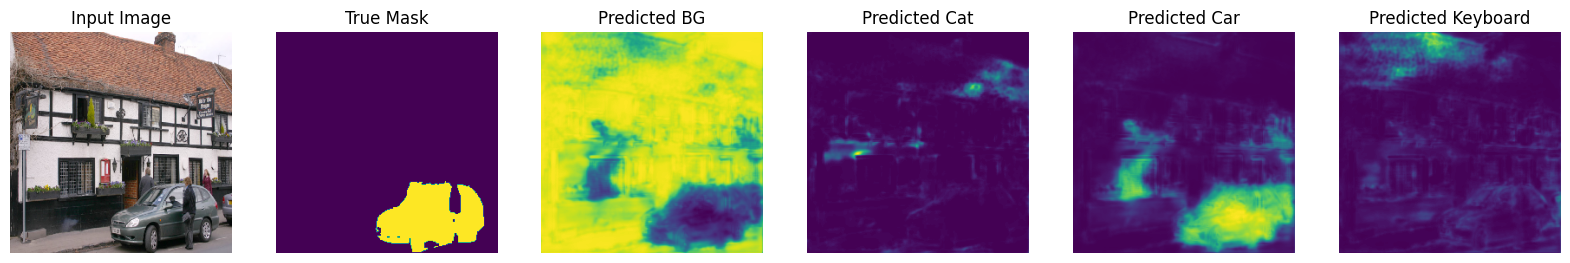

In [ ]:
model.eval()

img, mask = test_dataset[5]

with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device)).cpu().detach().squeeze()

display_list = [img, mask]
display_list.extend(torch.softmax(pred, dim=0))

display(display_list)

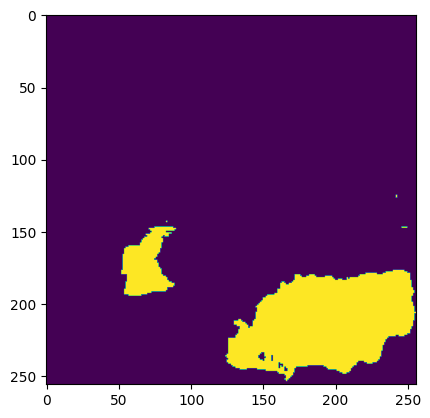

In [ ]:
pred_im = torch.softmax(pred, dim=0).argmax(0).byte()
pred_im = TF.to_pil_image(pred_im, mode='L')
plt.imshow(pred_im)

In [ ]:
model.eval()

model_outputs = []
GT = []

# Collect predictions and masks from batches
with torch.no_grad():
    for images, masks in test_dataloader:
        images = images.to(device)

        outputs = model(images)
        outputs = torch.softmax(outputs, dim=1)
        outputs = torch.argmax(outputs, dim=1)

        model_outputs.extend(outputs.cpu().numpy())
        GT.extend(masks.numpy())

In [ ]:
model_outputs = np.array(model_outputs).flatten()
GT = np.array(GT).flatten()

In [ ]:
f1_score(GT, model_outputs, average='micro')

0.7894713596631122

In [ ]:
f1_score(GT, model_outputs, average='macro')

0.6820750058290461

In [ ]:
dice_list = []

for i in range(4):
    outputs_temp = (model_outputs == i).astype('int')
    masks_temp = (GT == i).astype('int')
    intersection = np.sum(outputs_temp * masks_temp)
    dice = (2 * intersection) / (np.sum(outputs_temp) + np.sum(masks_temp))
    dice_list.append(dice)

dice_list

[0.8583261659981462,
 0.6913648079143279,
 0.4990273948412465,
 0.6795816545624639]